In [2]:
#!pip install cffi
#!pip install adi-reader
#!pip install seaborn
#!pip install pyyaml
import os
import pandas as pd
import numpy as np
import adi
import matplotlib.pyplot as plt
from skimage.morphology import binary_erosion, binary_dilation
from skimage.measure import label
import seaborn as sns
colormap = plt.cm.coolwarm_r
plt.style.use('dark_background')

In [10]:
directory = r"F:\Data\250408\abm001\250408\abm001.adicht"
f = adi.read_file(directory)
print(f.n_records)
print(f.channels)

2
[        h: <cdata 'struct ADI_FileHandle__ * *' owning 8 bytes>
       id: 1
n_records: 2
  tick_dt: [0.001, 0.001]
  records: Type::list, Len: 2
     name: Channel 1
    units: ['V', 'V']
n_samples: [5694850, 1068500]
       dt: [0.001, 0.001]
       fs: [1000.0, 1000.0]
,         h: <cdata 'struct ADI_FileHandle__ * *' owning 8 bytes>
       id: 2
n_records: 2
  tick_dt: [0.001, 0.001]
  records: Type::list, Len: 2
     name: Channel 2
    units: ['V', 'V']
n_samples: [5694850, 1068500]
       dt: [0.001, 0.001]
       fs: [1000.0, 1000.0]
,         h: <cdata 'struct ADI_FileHandle__ * *' owning 8 bytes>
       id: 3
n_records: 2
  tick_dt: [0.001, 0.001]
  records: Type::list, Len: 2
     name: Channel 3
    units: ['mV', 'mV']
n_samples: [5694850, 1068500]
       dt: [0.001, 0.001]
       fs: [1000.0, 1000.0]
]


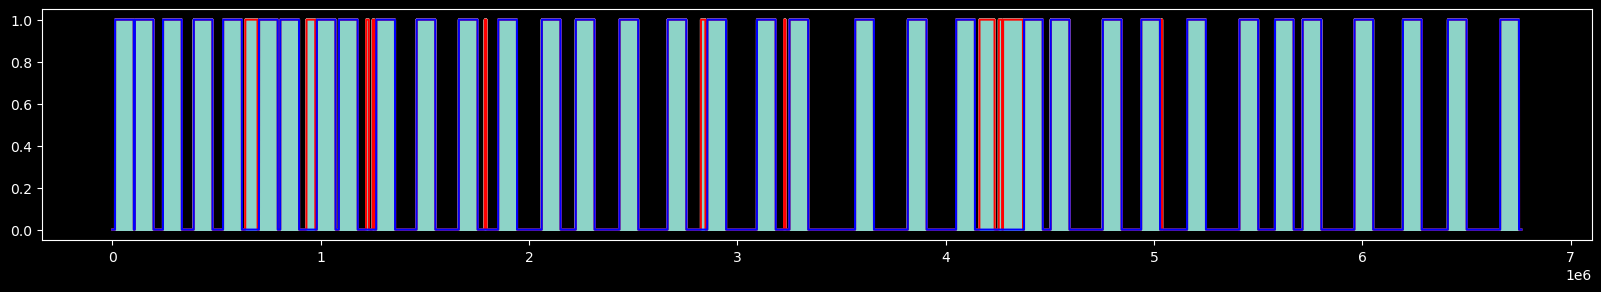

In [11]:
vid = np.array([])
n_recs = f.n_records
for i in range(1, n_recs+1):
    channel_id = 2 #channel index where referense recording is
    record_id = i
    data = f.channels[channel_id-1].get_data(record_id) 

    init = np.concatenate((vid, data))
    vid = np.concatenate((vid, data))

vid[vid <= 3] = 0
vid[vid > 3] = 1 

kernel_size = 100
kernel = np.ones((kernel_size))
dilated = binary_dilation(vid, footprint = kernel)
eroded = binary_erosion(dilated, kernel)
labeled = label(eroded)

filtered_labeled = np.zeros_like(labeled)


# Alternative approach using the labeled array directly
unique_values, counts = np.unique(labeled, return_counts=True)
valid_indices = []
for i, count in enumerate(counts):
    if i > 0:  # Skip background (index 0)
        if (110000 <= count <= 140000) or (87000 <= count <= 93000):
            valid_indices.append(i)
            filtered_labeled = np.zeros_like(labeled)
for idx in valid_indices:
    filtered_labeled[labeled == idx] = 1

recorded_indx = filtered_labeled



plt.figure(figsize=(20, 3))
#plt.plot(recorded_indx)
plt.plot(vid)
plt.plot(eroded, color = "red")
plt.plot(recorded_indx, color = "blue")

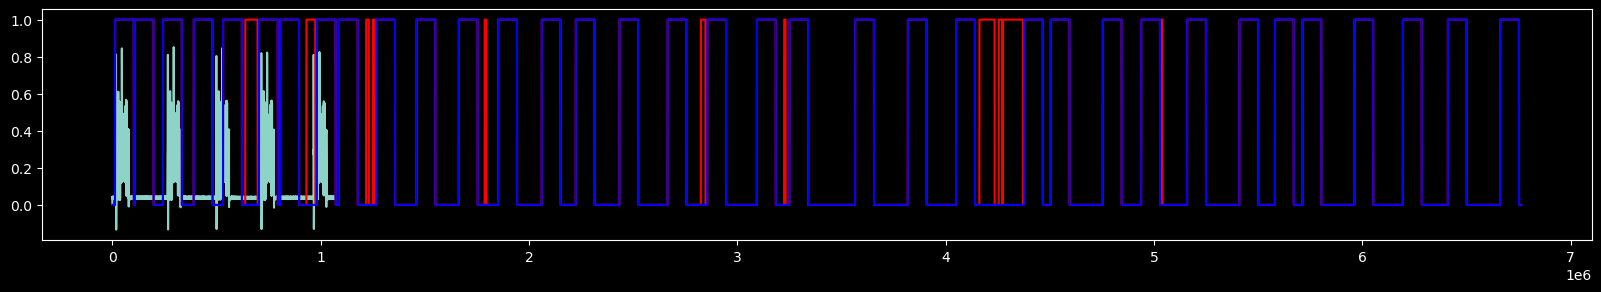

In [12]:
plt.figure(figsize=(20, 3))
#plt.plot(recorded_indx)
plt.plot(f.channels[0].get_data(record_id))
plt.plot(eroded, color = "red")
plt.plot(recorded_indx, color = "blue")

In [13]:
def extract_frames_full(rec_indx, emg):
    sequences = {}  
    sequence = label(rec_indx)  
    n_parts = np.max(sequence)
    for i in range(1, n_parts+1):
        mov_indx = np.where(sequence == i)[0]
        emg_sequence = emg[mov_indx] 
        key = f'sequence{i}' 
        sequences[key] = emg_sequence  
    return sequences

In [14]:
channels_to_extract = [0] #list of channels you wnat to apply mask on
recording = np.array([])
for  i in channels_to_extract:
    channel_id = i
    for j in range(1, f.n_records + 1):
        record_id = j
        data = f.channels[channel_id].get_data(record_id)
        recording = np.concatenate((recording, data))
        
        
seq_full = extract_frames_full(recorded_indx, recording)
#recording = []
filename = os.path.basename(directory)
dir_path = os.path.dirname(directory)
n_parts = np.max(label(recorded_indx))
for mov in range(1, n_parts+1):
    rec = (seq_full["sequence"+str(mov)])
    df = pd.DataFrame(rec, columns=['value'])
    df.to_csv(dir_path+"/"+ filename + "_rec" + str(mov) + ".txt")    